# 1. Importing Modules and Loading Data

In [1]:
# general functions
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
# visualization
from PIL import Image
# identifying faces


# visualizing bounding boxes
import matplotlib.patches as patches
# CNN
import keras
from sklearn.model_selection import train_test_split
# Moving files between directories
import shutil
from shutil import unpack_archive
from subprocess import check_output

dataset_path = "C:\\Users\\faken\\Documents\\Face Recognition\\input\\lfw-deepfunneled\\lfw-deepfunneled"

Using TensorFlow backend.


In [2]:
# Data read-in and cleaning

lfw_allnames = pd.read_csv("C:\\Users\\faken\\Documents\\Face Recognition\\input\\lfw_allnames.csv")
matchpairsDevTest = pd.read_csv("C:\\Users\\faken\\Documents\\Face Recognition\\input\\matchpairsDevTest.csv")
matchpairsDevTrain = pd.read_csv("C:\\Users\\faken\\Documents\\Face Recognition\\input\\matchpairsDevTrain.csv")
mismatchpairsDevTest = pd.read_csv("C:\\Users\\faken\\Documents\\Face Recognition\\input\\mismatchpairsDevTest.csv")
mismatchpairsDevTrain = pd.read_csv("C:\\Users\\faken\\Documents\\Face Recognition\\input\\mismatchpairsDevTrain.csv")
pairs = pd.read_csv("C:\\Users\\faken\\Documents\\Face Recognition\\input\\pairs.csv")
# tidy pairs data: 
pairs = pairs.rename(columns ={'name': 'name1', 'Unnamed: 3': 'name2'})
matched_pairs = pairs[pairs["name2"].isnull()].drop("name2",axis=1)
mismatched_pairs = pairs[pairs["name2"].notnull()]
people = pd.read_csv("C:\\Users\\faken\\Documents\\Face Recognition\\input\\people.csv")
# remove null values
people = people[people.name.notnull()]
peopleDevTest = pd.read_csv("C:\\Users\\faken\\Documents\\Face Recognition\\input\\peopleDevTest.csv")
peopleDevTrain = pd.read_csv("C:\\Users\\faken\\Documents\\Face Recognition\\input\\peopleDevTrain.csv")

# 2. Initial Data Analysis 

In [3]:
print("Summary:")
print("There are " + 
      str(lfw_allnames.shape[0]) + 
      " unique celebrities in the entire dataset, of whom " + 
      str(sum(lfw_allnames.images > 1)) + 
      " are represented by multiple images. The entire number of images available is " + 
      str(sum(lfw_allnames.images)) + 
      ". The most represented celebrity is " + 
      str(lfw_allnames.iloc[lfw_allnames['images'].idxmax()][0]) + 
      ", with " + 
      str(max(lfw_allnames.images)) + 
      " unique images in the dataset.")

Summary:
There are 5749 unique celebrities in the entire dataset, of whom 1680 are represented by multiple images. The entire number of images available is 13233. The most represented celebrity is George_W_Bush, with 530 unique images in the dataset.




**lfw_allnames.csv**: a CSV containing two columns; name (a list of all names in the entire dataset) and images (the number of images available for the each name) <br/>
**matchpairsDevTest**: a random sample of 500 image pairs featuring the same individual, with columns for the name and the two image labels <br/>
**matchpairsDevTrain**: a random sample of 1100 image pairs featuring the same individual, with columns for the name and the image labels <br/>
**mismatchpairsDevTest**: a random sample of 500 image pairs featuring different individuals, with columns for both names and the two image labels <br/>
**mismatchpairsDevTrain**: a random sample of 1100 image pairs featuring different individuals, with columns for both names and the two image labels <br/>
**pairs.csv**: 6000 pairs of images, both matched and mismatched. Matched pair rows contain a name and two image files, while unmatched pair rows contain a name for each of the images. For further formating, these two sets of rows will be split into matched_pairs and unmatched_pairs data frames <br/>
**people.csv**: list of names and image counts, identical to lfw_allnames.csv once null values have been removed. Omit from further analysis <br/>
**peopleDevTest.csv**: 1711 individuals in the dataset designed for testing: columns for celebrity name and image count (zero overlap with peopleDevTrain.csv) <br/>
**peopleDevTrain.csv**: 4038 individuals in the dataset designed for training: columns for celebrity name and image count (zero overlap with peopleDevTest.csv) <br/>

In addition, we have a catalogue of deepfunneled LFW images, created by Gary B. Huang, Marwan Mattar, Honglak Lee, and Erik Learned-Miller (details [here](http://vis-www.cs.umass.edu/papers/nips2012_deep_congealing.pdf)). This is the most useful dataset created by the LFW team, as the images have been rotated and sized to ensure consistent alignment prior to analysis, leading to stronger results when image recognition algorithms are applied to the dataset. 

### Data reshaping and train/test split

We need to define the objective more clearly before we create the train/test split. What are we trying to achieve with this project?<br/>

The flow of the project should be as follows: <br/>
1. Build a model on the training data that can predict the names associated with images <br/>
The training set should incorporate multiple images of some individuals, to equip the model with knowledge of how to deal with the same face in different situations
2. Test the model on new images and predict the identity <br/>
The test set needs to incorporate some individuals that we have seen in the training set (although not the same images) and some individuals that we haven't, to test the algorithm's accuracy

Therefore, we need to split the data into training and test data.

In [4]:
# shape data frame so there is a row per image, matched to relevant jpg file
image_paths = lfw_allnames.loc[lfw_allnames.index.repeat(lfw_allnames['images'])]
image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
image_paths['image_path'] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))
image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
image_paths = image_paths.drop("images",1)

# take a random sample: 80% of the data for the test set
lfw_train, lfw_test = train_test_split(image_paths, test_size=0.2)
lfw_train = lfw_train.reset_index().drop("index",1)
lfw_test = lfw_test.reset_index().drop("index",1)

# verify that there is a mix of seen and unseen individuals in the test set
print(len(set(lfw_train.name).intersection(set(lfw_test.name))))
print(len(set(lfw_test.name) - set(lfw_train.name)))

# both comprehensively non-empty - we are ok to procede.
# N.B. although we don't use this training/test split in the following model, this is the format of the data we
# would use in applying models to the full dataset

857
840


### Image format exploration

In [5]:
# verify resolution of all images is consistent
widths = []
heights = []
files = image_paths.image_path
for file in files:
    path = "C:\\Users\\faken\\Documents\\Face Recognition\\input\\lfw-deepfunneled\\lfw-deepfunneled\\" + str(file)
    im = Image.open(path)
    widths.append(im.width)
    heights.append(im.height)

pd.DataFrame({'height':heights,'width':widths}).describe()

# all 250 x 250 resolution

,height,width
count,13233.0,13233.0
mean,250.0,250.0
std,0.0,0.0
min,250.0,250.0
25%,250.0,250.0
50%,250.0,250.0
75%,250.0,250.0
max,250.0,250.0


### Further data exploration

One of the drawbacks of the LFW dataset is that if has significant class imbalance. This can be dealt with using selective sampling, but it is useful to get an indication of the scale of the imbalance:

<AxesSubplot:>

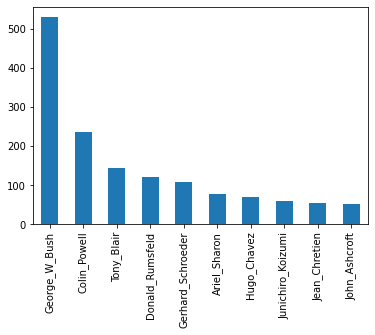

In [6]:
image_paths['name'].value_counts()[:10].plot(kind = "bar")

We can see that there are some very well-represented figures among the top 10: generally political and generally male. This has important implications for the usefulness of this dataset in generalizations, which we consider in the conclusion. To draw this further into distinction, how many individuals are represented by a single image, compared to George W Bush's 530? 

In [7]:
ind_counts = image_paths.groupby('name').count().image_path
print(str(sum(ind_counts[ind_counts==1])) + " individuals, which is " + str(round(100*(sum(ind_counts[ind_counts==1])/sum(ind_counts)))) + "% of the total individuals considered, are only represented by a single image in this dataset.")

4069 individuals, which is 31% of the total individuals considered, are only represented by a single image in this dataset.


As a sanity check, and to check the directories are all correctly connected, we visualize a sample image:

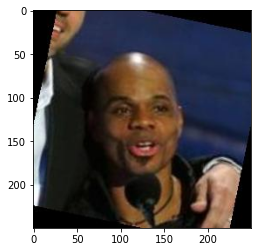

In [8]:
im = Image.open("C:\\Users\\faken\\Documents\\Face Recognition\\input\\lfw-deepfunneled\\lfw-deepfunneled\\" + str(lfw_train.image_path[0]))
plt.imshow(im)

## 3. Classifying Faces: CNN Approach on a Simplified Dataset
In this Section we will implement a classic CNN algorithm on the LFW dataset. Before we build any models, it is important to understand the structure and purpose of a CNN. There is a wealth of literature available, but the main themes are briefly synthesised below.

A Convolutional Neural Network (CNN) is a neural network used primarily for image analysis. Its primary insight is that image regions can be scanned to obtain lower-dimensional "convolved" representations that preserve the relationships between pixel areas. There are 4 key steps in a CNN:

1. **Convolution**: convolve the images using a feature detector to obtain a feature map (e.g. edge detection)
2. **Non-Linearity**: create non-linearities in the data using a non-linear activation function
3. **Pooling**: reduce dimension of the feature maps further by considering average convolved values in a region
4. **Connect the layers**: organise all previous aspects of the model into a fully connected network that can be used to generate model predictions

The network is then trained using back-propagation.

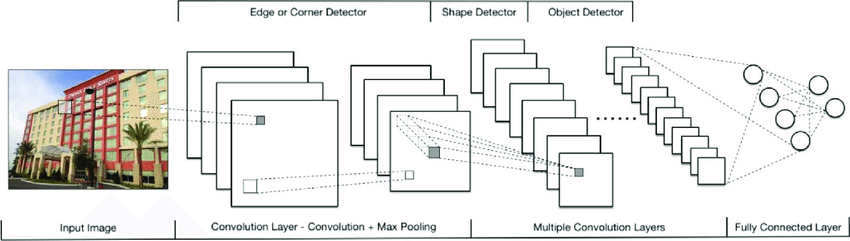
Illustration of the layers of a CNN (image from "Effects of user-provided photos on hotel review helpfulness: An analytical approach with deep leaning" (2018))

Traditional CNN works best when the classes are balanced, and when the classification method is binary, i.e. we are testing to see whether the images are in category A or B. We can recreate these conditions on a subset of the data, using the most well-sampled individual: George W Bush. The goal of this first-pass CNN is to identify whether an image is George W Bush or not; we use a random sample of the other images for category B. 

In [19]:
not_george = image_paths[image_paths.name!="George_W_Bush"].sample(530)
not_george.name = "not_George"
GWB_data = pd.concat([image_paths[image_paths.name=="George_W_Bush"],
                     not_george])

In [20]:
# withhold final test data
bush_train, bush_test = train_test_split(GWB_data, test_size=0.2)
#  It is also useful to reserve a validation set in the training data, for use in the model construction
bush_train, bush_val = train_test_split(bush_train,test_size=0.2)

In [21]:
# initialize sequential network
from keras.models import Sequential
# include convolutional layers
from keras.layers import Conv2D
# Pooling layers
from keras.layers import MaxPooling2D
# flatten layers into single vector
from keras.layers import Flatten
from keras.layers import Dense

In [22]:
# use sequential classifier - standard CNN implementation with straightforward single input
Bush_classifier = Sequential()
# We then add layers of complexity to this classifier. The first layer we add is a 2D convolutional layer (as 
# explained above); we pass over the image with a 3x3 window and expect 250*250 pixel input.
# The activation function to introduce non-linearity  is 'relu': Rectified Linear Units, a simple activation function 
# with low computational speeds. One potential downside is that ReLU can lead to "dying neurons", where a neuron is 
# attributed zero influence on classification and gets stuck in this state; we can see output where many neurons have 
# zero influence on the model. If this behaviour manifested in further analysis, an alternate activation function e.g. 
# 'leaky ReLU' would be worth exploring as an alternative
Bush_classifier.add(Conv2D(32, (3, 3), input_shape = (250, 250, 3), activation = 'relu'))

# We now add the pooling layer to reduce the dimension
Bush_classifier.add(MaxPooling2D(pool_size = (2, 2)))

# The next step is to flatten the data, reducing the feature maps to a 1D array
Bush_classifier.add(Flatten())

# We then add a fully connected layer - traditional Multi Layer Perceptron
Bush_classifier.add(Dense(units = 128, activation = 'relu'))

# as we are just training on 'Bush' vs 'non-Bush', we only need to add one classification unit
Bush_classifier.add(Dense(units = 1, activation = 'sigmoid'))

# We are now ready to compile the model. It is possible, and advisable, to introduce more layers to the network, but
# as this model is exploratory we are keeping things straightforward for now (this would change in future iterations)
Bush_classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

The model is now ready to run, but there is a final step required: the model will read training files from a dedicated training folder, so we need to make sure all the images are in folders with the correct labels. 

In [23]:
# define a custom function to move images to a new train/test/val directory

def directory_mover(data,dir_name):
    co = 0
    for image in data.image_path:
        # create top directory
        if not os.path.exists(os.path.join('C:\\Users\\faken\\Documents\\Face Recognition\\input\\working\\',dir_name)):
            shutil.os.mkdir(os.path.join('C:\\Users\\faken\\Documents\\Face Recognition\\input\\working\\',dir_name))
        
        data_type = data[data['image_path'] == image]['name']
        data_type = str(list(data_type)[0])
        if not os.path.exists(os.path.join('C:\\Users\\faken\\Documents\\Face Recognition\\input\\working\\',dir_name,data_type)):
            shutil.os.mkdir(os.path.join('C:\\Users\\faken\\Documents\\Face Recognition\\input\\working\\',dir_name,data_type))
        path_from = os.path.join('C:\\Users\\faken\\Documents\\Face Recognition\\input\\lfw-deepfunneled\\lfw-deepfunneled\\',image)
        path_to = os.path.join('C:\\Users\\faken\\Documents\\Face Recognition\\input\\working\\',dir_name,data_type)
        # print(path_to)
        shutil.copy(path_from, path_to)
        # print('Moved {} to {}'.format(image,path_to))
        co += 1
        
    print('Moved {} images to {} folder.'.format(co,dir_name))

In [24]:
# move images:
directory_mover(bush_train,"Bush_train/")
directory_mover(bush_val,"Bush_val/")
directory_mover(bush_test,"Bush_test/")


Moved 678 images to Bush_train/ folder.
Moved 170 images to Bush_val/ folder.
Moved 212 images to Bush_test/ folder.


Now all the images are in the relevant training/test folders, we can run our CNN algorithm.

In [25]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
Bush_training_set = train_datagen.flow_from_directory('C:\\Users\\faken\\Documents\\Face Recognition\\input\\working\\Bush_train\\',
                                                 target_size = (250, 250),
                                                 batch_size = 10,
                                                 class_mode = 'binary')
Bush_val_set = test_datagen.flow_from_directory('C:\\Users\\faken\\Documents\\Face Recognition\\input\\working\\Bush_val\\',
                                            target_size = (250, 250),
                                            batch_size = 10,
                                            class_mode = 'binary')
Bush_test_set = test_datagen.flow_from_directory('C:\\Users\\faken\\Documents\\Face Recognition\\input\\working\\Bush_test\\',
                                            target_size = (250, 250),
                                            batch_size = 10,
                                            class_mode = 'binary')

Found 678 images belonging to 2 classes.
Found 170 images belonging to 2 classes.
Found 212 images belonging to 2 classes.


In [26]:
Bush_history = Bush_classifier.fit_generator(Bush_training_set,
                                             # set steps per epoch equal to the number of training images
                                             steps_per_epoch = 528,
                                             epochs = 8,
                                             validation_data = Bush_val_set,
                                             validation_steps = 77)

Epoch 1/8
528/528 [==============================] - 69s 130ms/step - loss: 0.7083 - accuracy: 0.7802 - val_loss: 0.5076 - val_accuracy: 0.8364
Epoch 2/8
528/528 [==============================] - 66s 125ms/step - loss: 0.2484 - accuracy: 0.9007 - val_loss: 0.0636 - val_accuracy: 0.8922
Epoch 3/8
528/528 [==============================] - 64s 121ms/step - loss: 0.2092 - accuracy: 0.9181 - val_loss: 0.2846 - val_accuracy: 0.8740
Epoch 4/8
528/528 [==============================] - 63s 119ms/step - loss: 0.1736 - accuracy: 0.9329 - val_loss: 0.0123 - val_accuracy: 0.8844
Epoch 5/8
528/528 [==============================] - 64s 121ms/step - loss: 0.1760 - accuracy: 0.9303 - val_loss: 1.1580 - val_accuracy: 0.9156
Epoch 6/8
528/528 [==============================] - 68s 130ms/step - loss: 0.0881 - accuracy: 0.9669 - val_loss: 8.2371e-04 - val_accuracy: 0.9390
Epoch 7/8
528/528 [==============================] - 68s 129ms/step - loss: 0.0972 - accuracy: 0.9630 - val_loss: 0.3232 - val_accur

Now that the model is operational, we can look at the relationship between the training and validation loss to see if overfitting is likely to have taken place:

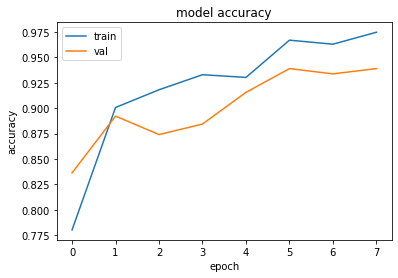

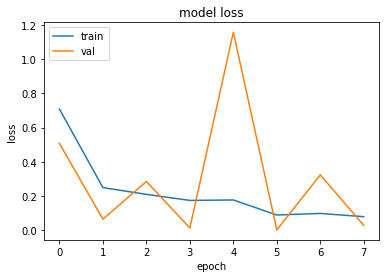

In [28]:
plt.plot(Bush_history.history['accuracy'])
plt.plot(Bush_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(Bush_history.history['loss'])
plt.plot(Bush_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Given the relatively low number of epochs, the model still appears to be converging - the validation loss/accuracy is instable, which is also a function of the validation method (in future iterations, cross validation would be a preferable method). However, accuracy is generally high on both sets, indicating that the model is performing well. To confirm the model's performance, we look at the precision and recall on the (unseen) test set, comparing accuracy with the true labels:

In [29]:
print(Bush_history.history['accuracy'][-1])

0.97473407


In [30]:
from keras.preprocessing import image

# create a function to predict class of images in a directory, given a trained classifier
def predictions(dir_name,classifier,binary):
    # dir_name should include name of predicted invididual - could edit this to iterate through folders in future
    predictions = []
    for im in os.listdir(dir_name):
        test_image = image.load_img(dir_name + str(im), target_size = (250,250))
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis = 0)
        if(binary is True):
            result = float(str(classifier.predict(test_image))[2])
        else: 
            result = np.argmax(classifier.predict(test_image))
        predictions.append(result)
    return(predictions)


In [31]:
# function for finding the precision and recall of predictions, for any number of predictive classes
def prec_acc(predictions_frame):
    precision = []
    accuracy = []
    recall = []
    for i in range(len(set(predictions_frame.Predictions))):
        tp = predictions_frame[np.logical_and(predictions_frame['Actual'] == i, predictions_frame['Predictions'] == i)].shape[0]
        tn = predictions_frame[np.logical_and(predictions_frame['Actual'] != i, predictions_frame['Predictions'] != i)].shape[0]
        fp = predictions_frame[np.logical_and(predictions_frame['Actual'] != i, predictions_frame['Predictions'] == i)].shape[0]
        fn = predictions_frame[np.logical_and(predictions_frame['Actual'] == i, predictions_frame['Predictions'] != i)].shape[0]
        total_preds = predictions_frame.shape[0]
        precision.append(tp/(tp + fp))
        accuracy.append((tp + tn)/total_preds)
        recall.append(tp/(tp + fn))
    return(accuracy,precision,recall)

## 4. Classifying Faces: Multiple Classes Using a Classic CNN
The immediate logical extension of this problem is to extend analysis to multiple classes. With enough time, we could exactly replicate this approach on the entire dataset, using every identity as a separate class. However, given time constraints, we can consider a brief extension to explore the strengths and limitations of a simple CNN model. Instead of taking Bush and non-Bush images, we will take an arbitrary cut-off of the 6 most frequently occurring celebrities and attempt to classify the images.

In [11]:
# obtain 6 most common celebrities

image_paths['name'].value_counts()[:6]

George_W_Bush        530
Colin_Powell         236
Tony_Blair           144
Donald_Rumsfeld      121
Gerhard_Schroeder    109
Ariel_Sharon          77
Name: name, dtype: int64

There is a clear issue with class imbalance here: to ensure more balanced classes, we could up-sample some of the low-representation individuals, but in the interests of algorithmic speed we will instead down-sample the high-representation individuals:

In [12]:
multi_data = pd.concat([image_paths[image_paths.name=="George_W_Bush"].sample(75),
                        image_paths[image_paths.name=="Colin_Powell"].sample(75),
                        image_paths[image_paths.name=="Tony_Blair"].sample(75),
                        image_paths[image_paths.name=="Donald_Rumsfeld"].sample(75),
                        image_paths[image_paths.name=="Gerhard_Schroeder"].sample(75),
                        image_paths[image_paths.name=="Ariel_Sharon"].sample(75)])

We then run the model as before, adjusting for multiple classes:

In [17]:
# withhold final test data
multi_train, multi_test = train_test_split(multi_data, test_size=0.2)
# split into validation data
multi_train, multi_val = train_test_split(multi_train,test_size=0.2)

# Same model setup as before
multi_classifier = Sequential()
multi_classifier.add(Conv2D(32, (3, 3), input_shape = (250, 250, 3), activation = 'relu'))
multi_classifier.add(MaxPooling2D(pool_size = (2, 2)))
multi_classifier.add(Flatten())
multi_classifier.add(Dense(units = 128, activation = 'relu'))

# as we are training on several classes, we need several classification units (one for each class). We also use a 
# softmax activation function
multi_classifier.add(Dense(units = 6, activation = 'softmax'))
# we change the loss function to categorical_crossentropy
multi_classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# move images to separate directories
directory_mover(multi_train,"train_multi/")
directory_mover(multi_val,"val_multi/")
directory_mover(multi_test,"test_multi/")

train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
multi_training_set = train_datagen.flow_from_directory('C:\\Users\\faken\\Documents\\Face Recognition\\input\\working\\train_multi\\',
                                                 target_size = (250, 250),
                                                 batch_size = 5,
                                                 class_mode = 'categorical')
multi_val_set = test_datagen.flow_from_directory('C:\\Users\\faken\\Documents\\Face Recognition\\input\\working\\val_multi\\',
                                            target_size = (250, 250),
                                            batch_size = 5,
                                            class_mode = 'categorical')
multi_test_set = test_datagen.flow_from_directory('C:\\Users\\faken\\Documents\\Face Recognition\\input\\working\\test_multi\\',
                                            target_size = (250, 250),
                                            batch_size = 5,
                                            class_mode = 'categorical')


multi_history = multi_classifier.fit_generator(multi_training_set,
                                               # set steps per epoch equal to the number of training images
                                               steps_per_epoch = 288,
                                               # as the data is smaller, we can run for more epochs
                                               epochs = 14,
                                               validation_data = multi_val_set,
                                               validation_steps = 72)

Moved 288 images to train_multi/ folder.
Moved 72 images to val_multi/ folder.
Moved 90 images to test_multi/ folder.
Found 600 images belonging to 6 classes.
Found 199 images belonging to 6 classes.
Found 242 images belonging to 6 classes.
Epoch 1/14
288/288 [==============================] - 30s 105ms/step - loss: 3.1513 - accuracy: 0.3118 - val_loss: 1.6675 - val_accuracy: 0.3760
Epoch 2/14
288/288 [==============================] - 28s 98ms/step - loss: 1.3116 - accuracy: 0.5146 - val_loss: 0.5308 - val_accuracy: 0.5251
Epoch 3/14
288/288 [==============================] - 28s 98ms/step - loss: 0.9885 - accuracy: 0.6583 - val_loss: 1.8120 - val_accuracy: 0.7291
Epoch 4/14
288/288 [==============================] - 28s 98ms/step - loss: 0.6193 - accuracy: 0.7868 - val_loss: 0.2921 - val_accuracy: 0.7905
Epoch 5/14
288/288 [==============================] - 28s 98ms/step - loss: 0.5068 - accuracy: 0.8326 - val_loss: 0.3289 - val_accuracy: 0.8547
Epoch 6/14
288/288 [==================

Again, it is useful to check for convergence:

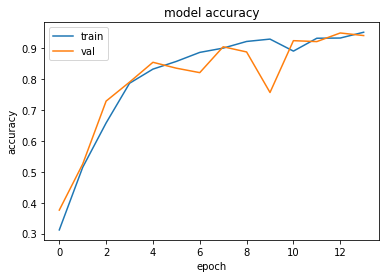

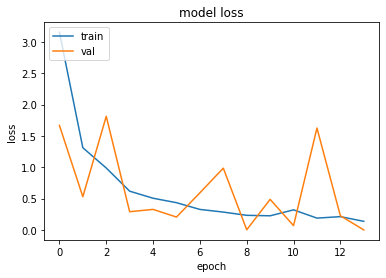

In [32]:
plt.plot(multi_history.history['accuracy'])
plt.plot(multi_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(multi_history.history['loss'])
plt.plot(multi_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Model loss appears broadly stable over 14 epochs; we do not seem to have reached the point of overfitting yet.

In [33]:
print(multi_history.history['accuracy'][-1])

0.95208335


# 5. Results Analysis
On repeated runs of the George Bush model, we obtained a precision of around 81% and a recall of around 98%. In other words, 95% of the images we say are George Bush actually are George Bush, and 81% of the pictures of George Bush are identified as pictures George Bush. What does this mean in the real world?

Precision is the metric we are most interested in, and the value of around 81% indicates that only 19% of the images we say are George Bush are in fact someone else. Is this acceptable? It is likely the answer is no. In news labelling, it is likely that there would be a human on hand to QA results before they reach the public, but in live video labelling these errors are likely to be too prevalent to be useful and could lead to embarrassing mistakes. A recall rate of somewhere around 99.5%+, or <$\frac{5}{1000}$ errors of this nature, would give more confidence before committing this model to production. However, as discussed in Section 3, this very high recall value could give us confidence in applying this model to a different context where there is a high cost associated with false negatives.

How does accuracy look in the 6-individual model? Precision and recall are of similar volume but vary more between classes. Indeed, in the final model run before publishing this notebook, precision averaged around 0.8\* for all classes aside from one: the model's performance on Tony Blair images gave very low precision (0.41\*), as many of the Tony Blair test images were mis-classified as images of George W Bush. For the same reason, recall was low for the George W Bush class. Rather than being a slightly dated piece of satire, this indicates the potential drawbacks of a shallow network trained on low data volumes when tasked with identifying individuals who have similar demographics and tend to appear in similar pictures. This problem could be addressed by adding more complexity to the model.

\**final figures may vary due to differences in sampling and model initialization*

# 6. Conclusion and Next Steps
In this notebook, we have successfully run two CNN-based models using images from the LFW dataset: a two-class identifier that achieved precision of around 97.5% in 7 mins, and a six-class discriminator that achieved a similar precision (95.2%) . Thus, we have demonstrated that the CNN framework generalizes reasonably well to multiple classes, even when data volumes are relatively small, the CNN algorithm is simple, and the training time is low. However, there are several ways we could both improve the current model or extend to a different model that would likely bring higher accuracy and more reliable results.

### Future Model Improvements
The best way to improve the model is by implementing more sophisticated model extensions. As discussed in Section 4d, there are two key routes for this method: YOLO, if rapid implementation is required, or Faster R-CNN with transfer learning, if optimal model accuracy is key. Based on previous results in the CNN literature, either of these methods should give strong improvements in speed and accuracy. 

Within the CNN infrastructure built in Section 4, there are several immediate improvements that we would make in future work, many of which are listed above: running for more epochs, on more classes, with more complex layers in the model. The first improvement would be in the model construction stage: the validation data is currently a single set, which with enough epochs can lead to overfitting on the validation data. Given the reasonable model performance on the test data, there doesn't seem to be a huge amount of overfitting, although it potentially manifests in the higher epochs of the six-class model. 10-fold cross validation would be preferable to a simple training/validation split.

Another important limitation around the model as it currently stands is its data input. As mentioned on the [LFW data source page](http://vis-www.cs.umass.edu/lfw/), there is large bias in the image selection around age, ethnicity and gender. Even after extending the model to encapsulate all the images, the utility of any trained model is always going to be hampered by this bias - predictions are only going to be accurate for the individuals represented in the dataset. A solution to this could be to incorporate more datasets in the training model, to increase its diversity and generalization (and therefore its impartiality). Some candidate datasets for this step are available at [http://www.face-rec.org/databases/](http://www.face-rec.org/databases/).

The final element to consider is the large class imbalance in the whole dataset. Up-sampling and down-sampling can be effective techniques when we have a small number of classes, or the class imbalance is small, but when the largest category has 500 times more images than the smallest then smarter tools are needed. This problem was considered in detail by the [Facebook AI Research Team](https://arxiv.org/pdf/1708.02002.pdf), who used focal loss (a weighted application of cross-entropy loss) to allocate "attention" to incorrect inferences. Exploring this loss function would be vital in obtaining an optimal model on the whole dataset.
